# Examples of pyqrse with Skewed Data

### imports

In [9]:
# %load imports.py
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from pandas import Series, DataFrame
from tabulate import tabulate
from IPython.display import Latex 
from tqdm import tqdm
from collections import defaultdict

import copy
import csv
import datetime
import time
import os

os.chdir("..")

import pyqrse
from pyqrse import QRSE
from pyqrse.utilities.helpers import mprint
from pyqrse.utilities.mathstats import asymmetric_laplace, inv_cdf_sampler

## create sample data

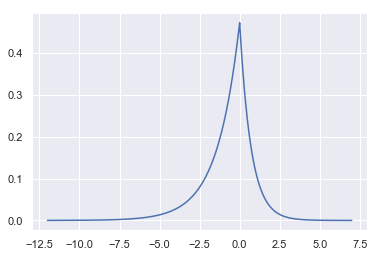

In [29]:
al = lambda x: asymmetric_laplace(x, 1, 1.4, 0)
ll = np.linspace(-12, 7, 1000)
plt.plot(ll, al(ll));

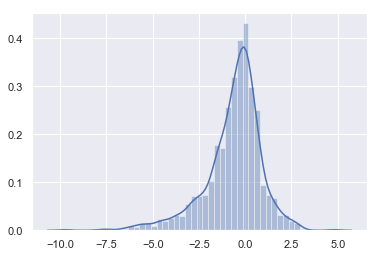

In [30]:
sample = inv_cdf_sampler(al, 1000,(-10, 7, 1000))
sns.distplot(sample);

## Compare Fits of Several Model

In [31]:
pyqrse.available_kernels()

 code    n_actions           class                long_name      
------------------------------------------------------------
  S    |     2      |   SQRSEKernel    |  Symmetric QRSE 
  AA   |     3      |   AAQRSEKernel   | Asymmetric-Action QRSE
 SNH   |     2      |  SQRSEKernelNoH  | Symmetric QRSE (No Entropy)
  SF   |     2      |   SFQRSEKernel   | Scharfenaker and Foley QRSE
 AAX   |     3      |  AAXQRSEKernel   | Asymmetric-Action(xi) QRSE
  AT   |     3      |   ATQRSEKernel   | Asymmetric-Temperature QRSE
  AX   |     3      |   AXQRSEKernel   | Asymmetric (xi) QRSE
 SFC   |     2      |  SFCQRSEKernel   | Scharfenaker and Foley QRSE (Centered)
 ABX   |     2      |  ABXQRSEKernel   | Asymmetric-Beta (xi) QRSE
ABXNH  |     2      | ABXQRSEKernelNH  | Asymmetric-Beta QRSE (Xi, No Entropy)
  A    |     3      |   AQRSEKernel    | Asymmetric QRSE 
 ABXC  |     2      |  ABXCQRSEKernel  | Asymmetric-Beta QRSE (Xi, Centered)
  AB   |     2      |   ABQRSEKernel   | Asymmetric-B

Estimate Multiple Models on the same data

In [32]:
codes = ['S', 'SF', 'ABX', 'AB', 'AA', 'AT', 'A']

print('QRSEModels in models and model_hash:\n')
models = []

for i, code in enumerate(codes):
    
    model = pyqrse.QRSE(code, data=sample)
    model.fit()
    models.append(model)
    print("{}. {}".format(i+1, model.long_name))

model_hash = dict(zip(codes, models))  

QRSEModels in models and model_hash:

1. Symmetric QRSE
2. Scharfenaker and Foley QRSE
3. Asymmetric-Beta (xi) QRSE
4. Asymmetric-Beta QRSE
5. Asymmetric-Action QRSE
6. Asymmetric-Temperature QRSE
7. Asymmetric QRSE


Compare model selection criteria

In [33]:

body = [['name', 'nll', 'aic', 'aicc', 'bic', 'success?']]
for model in models: 
    body.append([model.name, model.res.fun, model.aic(), 
                 model.aicc(), model.bic(), 
                 str(model.res.success)])
    
mprint(body, rb="-")

|     name     |   nll    |   aic    |   aicc   |   bic    | success? |
-----------------------------------------------------------------------
|    S-QRSE    |  1774.34 |  3554.67 |  3554.69 |  3569.39 |   True   |
-----------------------------------------------------------------------
|   SF-QRSE    |  1738.77 |  3487.55 |  3487.61 |  3512.08 |   True   |
-----------------------------------------------------------------------
| AB-QRSE (xi) |  1738.77 |  3487.55 |  3487.61 |  3512.08 |   True   |
-----------------------------------------------------------------------
|   AB-QRSE    |  1740.36 |  3488.72 |  3488.76 |  3508.35 |   True   |
-----------------------------------------------------------------------
|   AA-QRSE    |  1737.60 |  3485.20 |  3485.26 |  3509.74 |   True   |
-----------------------------------------------------------------------
|   AT-QRSE    |  1737.93 |  3483.85 |  3483.89 |  3503.48 |   True   |
----------------------------------------------------------------

Compare parameter estimates

In [34]:
print('sample mean = {: .3f}\n'.format(sample.mean()))
for model in models:
    print('\n', "{:9}".format(model.name), "*-"*20)
    print(("{: ^8}"*model.fn_params).format(*model.fpnames))
    print(("{: .4f} "*model.fn_params).format(*model.fparams))

sample mean = -0.636


 S-QRSE    *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t       b       m    
 0.6212  0.7102 -0.3663 

 SF-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t       b       m       g       xi   
 0.5543  0.7835  0.2370  0.1531 -0.6364 

 AB-QRSE (xi) *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t     b_buy     m     b_sell    xi   
 0.5543  0.6304  0.2370  0.9367 -0.6364 

 AB-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
   t     b_buy     m     b_sell 
 0.5994  0.5481 -0.0305  1.1234 

 AA-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell  m_buy   m_sell    b    
 0.5212  15.0824 -0.1770  3.1002  0.9602 

 AT-QRSE   *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell    m       b    
 0.5165  10.5713 -0.0637  0.9778 

 A-QRSE    *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
 t_buy   t_sell  m_buy   m_sell  b_buy   b_sell 
 0.5359  7.1258 -0.3883  5.1796  0.9970  0.7082 


Compare Fits of all data

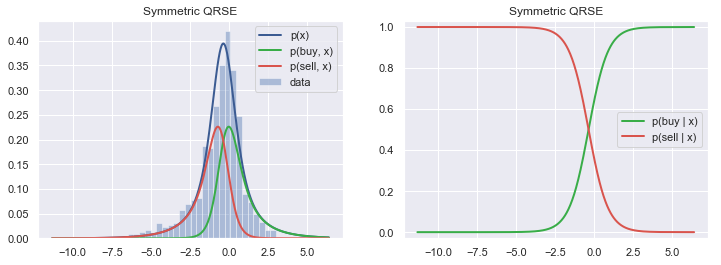

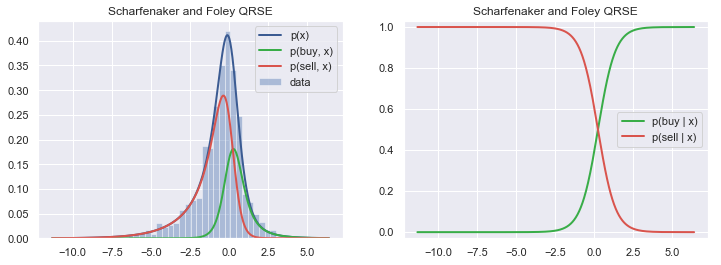

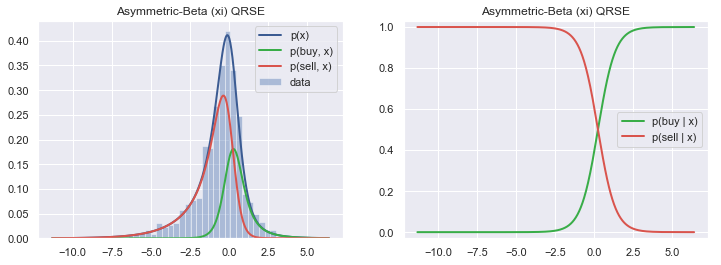

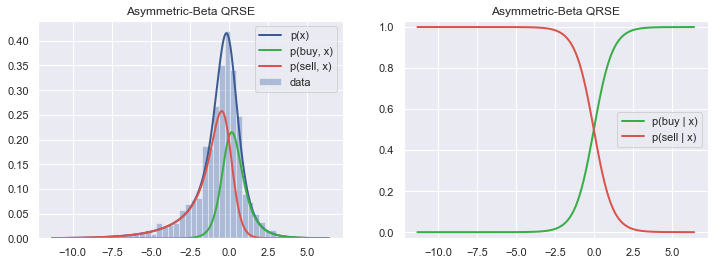

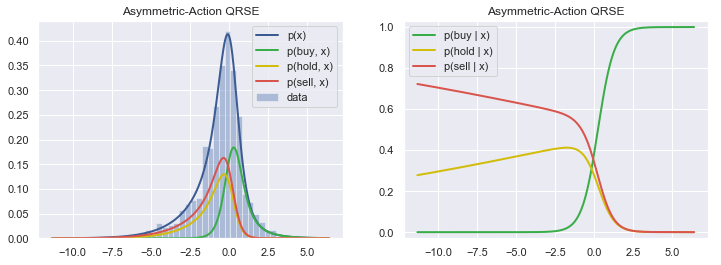

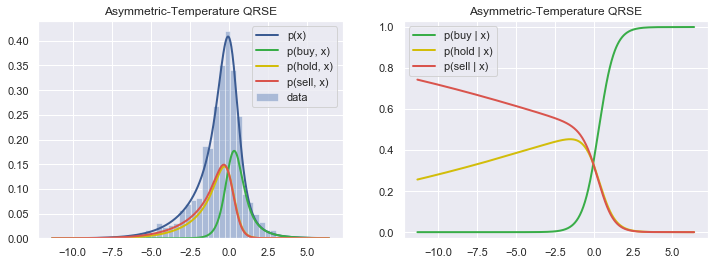

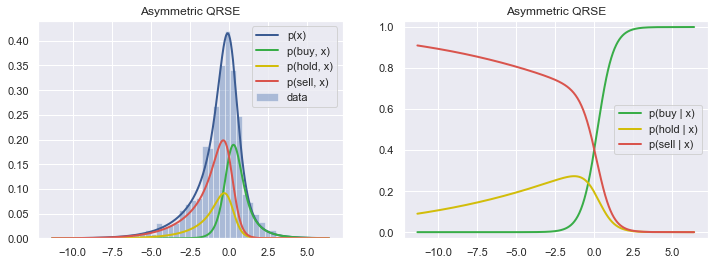

In [35]:
for i, model in enumerate(models):
    model.plotboth(bins=40)

## Compare Samplers

In [41]:
for model in models:
    
    print(model.kernel.long_name)
    model.sampler.chain_format='df'
    model.set_hess_inv(from_res=True)
    model.sampler.init()
    model.sampler.mcmc(20000, use_tqdm=False)
    
    print('')

Symmetric QRSE
hess is pos def? : True
[0.4518 0.     0.    ]

Scharfenaker and Foley QRSE
hess is pos def? : True
[0.3742 0.     0.     0.    ]

Asymmetric-Beta (xi) QRSE
hess is pos def? : True
[0.37975 0.      0.      0.     ]

Asymmetric-Beta QRSE
hess is pos def? : True
[0.38205 0.      0.      0.     ]

Asymmetric-Action QRSE
hess is pos def? : True
[0.19995 0.      0.      0.      0.     ]

Asymmetric-Temperature QRSE
hess is pos def? : True


/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:196: RuntimeWarning: invalid value encountered in true_divide
  p_buy, p_sell = e_b/part, e_s/part
/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:197: RuntimeWarning: invalid value encountered in true_divide
  entropy = -(e_b*vb + e_s*vs)/part + np.log(part)
/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:197: RuntimeWarning: overflow encountered in multiply
  entropy = -(e_b*vb + e_s*vs)/part + np.log(part)


[0.39835 0.      0.      0.     ]

Asymmetric QRSE
hess is pos def? : True


/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:247: RuntimeWarning: invalid value encountered in true_divide
  p_buy, p_sell = e_b/part, e_s/part
/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:249: RuntimeWarning: invalid value encountered in true_divide
  entropy = -(e_b*vb + e_s*vs)/part + np.log(part)
/Users/keithblackwell1/Documents/GoogStudy/py3qrse/pyqrse/kernels/ternarykernels.py:249: RuntimeWarning: overflow encountered in multiply
  entropy = -(e_b*vb + e_s*vs)/part + np.log(part)


[0.036 0.    0.    0.    0.    0.   ]



### Sampler Output: Asymmetric Beta QRSE

View Markov Chains

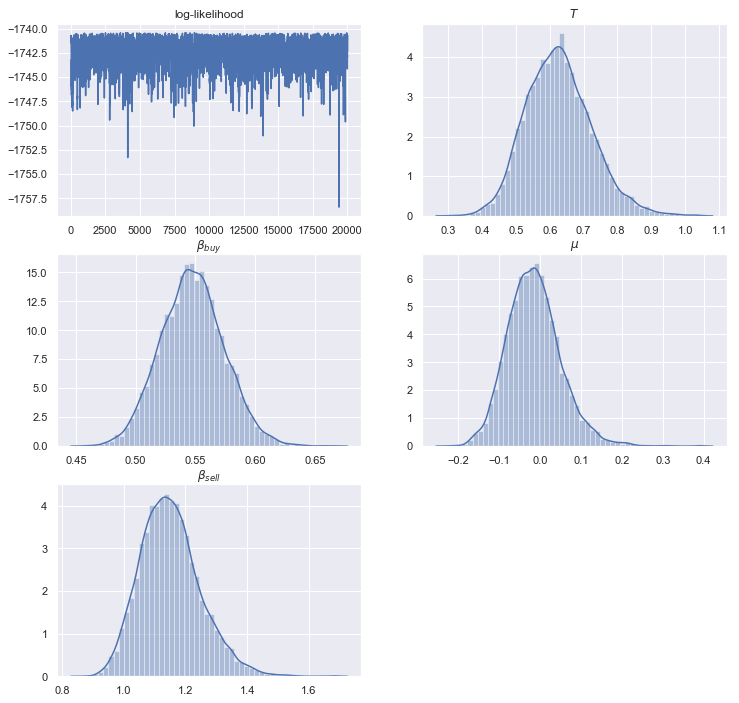

In [42]:
model_hash['AB'].sampler.plot()

view the difference between chains

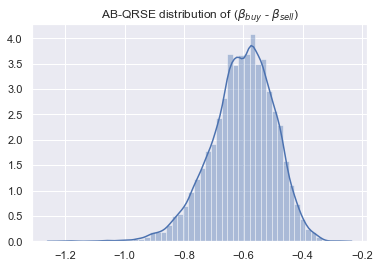

In [43]:
model_hash['AB'].sampler.plotdiff('b_buy', 'b_sell')

### Sampler Output: SF QRSE

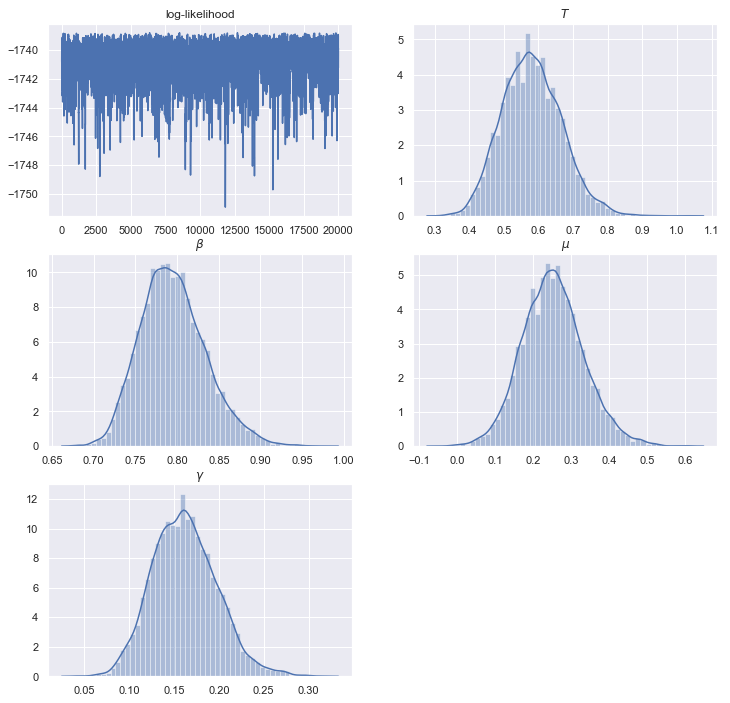

In [44]:
model_hash['SF'].sampler.plot()

### Sampler Output: Asymmetric QRSE

View the Markov Chain Output

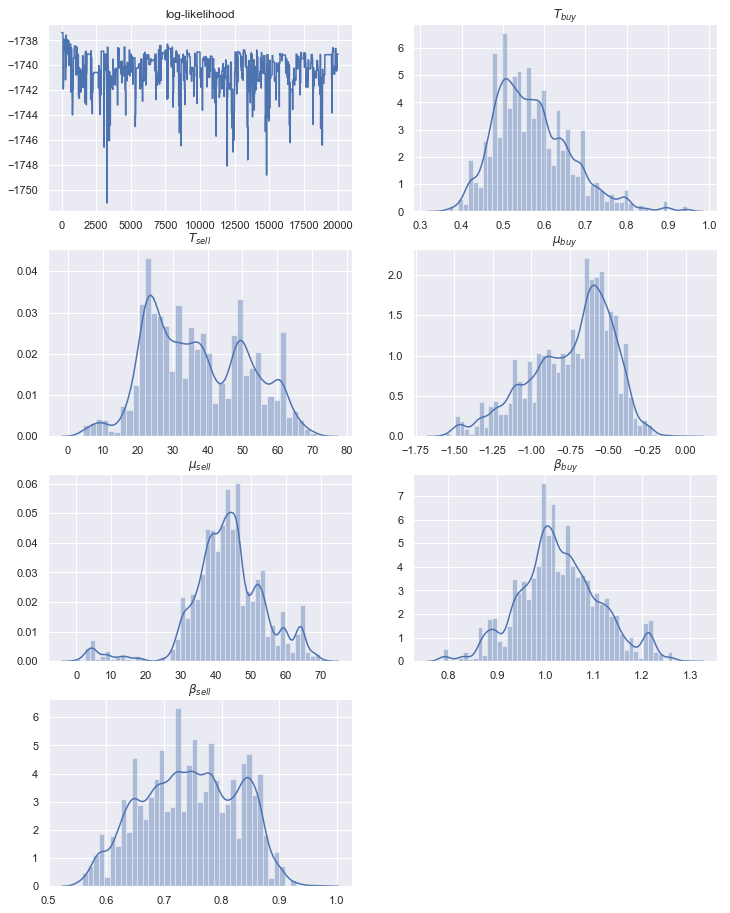

In [45]:
model_hash['A'].sampler.plot()

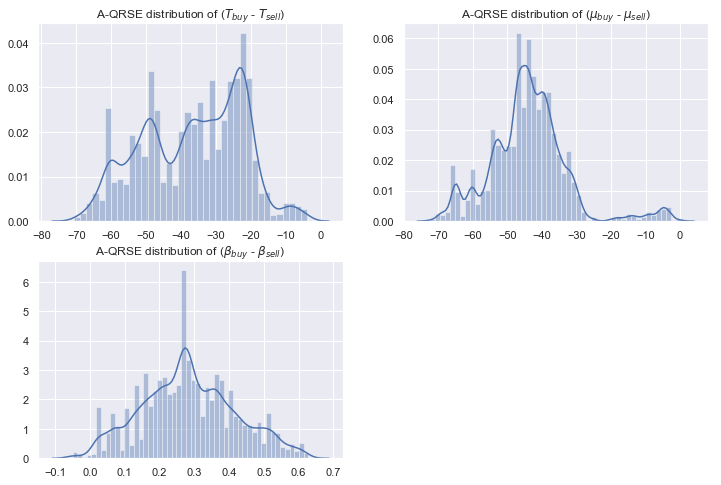

In [46]:
plt.figure(figsize=(12,8))
plt.subplot(221)
model_hash['A'].sampler.plotdiff('t_buy', 't_sell', kind='hist')
plt.subplot(222)
model_hash['A'].sampler.plotdiff('m_buy', 'm_sell', kind='hist')
plt.subplot(223)
model_hash['A'].sampler.plotdiff('b_buy', 'b_sell', kind='hist')